In [1]:
%%time
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn import cross_validation, ensemble, tree, metrics, preprocessing
from sklearn.grid_search import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
le = preprocessing.LabelEncoder()
import xgboost as xgb
from datetime import datetime, date
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

CPU times: user 1.23 s, sys: 468 ms, total: 1.69 s
Wall time: 3.93 s


In [ ]:
%%time
# Training files are divided into three separate files in six month increments
temp_train_2014_1 = pd.read_csv('CAX_Train_2014_Jan_to_Jun.csv')
temp_train_2014_2 = pd.read_csv('CAX_Train_2014_Jul_to_Dec.csv')
temp_train_2015 = pd.read_csv('CAX_Train_2015.csv')

# Read in the weather file
weather = pd.read_csv('weather.csv')

# The codes file is a manual matching I created between the IATA codes in the training files and
# the ICAO codes in the weather file. Multiple IATA codes can join to the same ICAO codes based on proximity to 
# cities. City names in the training files can be truncated and often did not match the weather file. If the
# matching wasn't obvious based on the IATA and ICAO codes then IATA code were looked up in Google to determine the
# nearest ICAO city.
codes = pd.read_csv('training_weather_cities_joined.csv')

In [3]:
%%time
# Creating week of year field in order to group weather events by week
weather['week_of_year'] = pd.to_datetime(weather['date'], errors='coerce').dt.weekofyear.astype(int)

# Some basic munging of weather fields
weather.events.fillna(-1, inplace=True)
weather.conditions.fillna(-1, inplace=True)
weather.gust_speed_mph.replace('-', -1, inplace=True)
weather.gust_speed_mph.fillna(-1, inplace=True)
weather.gust_speed_mph = pd.to_numeric(weather.gust_speed_mph, errors='coerce')
weather.wind_speed_mph.replace('Calm', 0, inplace=True)
weather.wind_speed_mph.fillna(-1, inplace=True)
weather.wind_speed_mph = pd.to_numeric(weather.wind_speed_mph, errors='coerce')

# Changing to weather types in the events field to numeric values based on the likelihood of causing delays
# e.g. Events involving ice have a higher value
weather.events.replace(['Fog',
'Fog-Hail-Thunderstorm',
'Fog-Rain',
'Fog-Rain-Hail-Thunderstorm',
'Fog-Rain-Snow',
'Fog-Rain-Thunderstorm',
'Fog-Rain-Thunderstorm-Tornado',
'Fog-Snow',
'Fog-Snow-Thunderstorm',
'Fog-Thunderstorm',
'Hail',
'Hail-Thunderstorm',
'Rain',
'Rain-Hail',
'Rain-Hail-Thunderstorm',
'Rain-Snow',
'Rain-Snow-Thunderstorm',
'Rain-Thunderstorm',
'Rain-Thunderstorm-Tornado',
'Rain-Tornado',
'Snow',
'Snow-Hail',
'Snow-Thunderstorm',
'Snow-Tornado',
'Thunderstorm',
'Thunderstorm-Tornado',
'Tornado'], [10,
80,
20,
80,
60,
50,
100,
60,
60,
50,
80,
80,
20,
80,
80,
60,
60,
50,
100,
100,
60,
80,
60,
100,
50,
100,
100], inplace=True)

# As with the events field, changing the conditions field to numeric values based on the likelihood of causing delays
weather.conditions.replace(['Unknown',
'Clear',
'Overcast',
'Partly Cloudy',
'Drizzle',
'Scattered Clouds',
'Mostly Cloudy',
'Haze',
'Mist',
'Patches of Fog',
'Rain',
'Shallow Fog',
'Low Drifting Snow',
'Rain Showers',
'Light Blowing Snow',
'Light Drizzle',
'Light Fog',
'Light Hail',
'Light Ice Pellets',
'Light Low Drifting Snow',
'Light Mist',
'Light Rain',
'Light Rain Showers',
'Light Sand',
'Light Small Hail Showers',
'Light Smoke',
'Light Snow',
'Light Snow Grains',
'Light Snow Showers',
'Light Thunderstorm',
'Light Thunderstorms and Rain',
'Light Thunderstorms and Snow',
'Light Thunderstorms with Hail',
'Light Thunderstorms with Small Hail',
'Heavy Blowing Snow',
'Heavy Drizzle',
'Heavy Freezing Drizzle',
'Heavy Freezing Fog',
'Heavy Freezing Rain',
'Heavy Ice Pellets',
'Heavy Rain',
'Heavy Rain Showers',
'Heavy Small Hail',
'Heavy Snow',
'Heavy Snow Showers',
'Heavy Thunderstorm',
'Heavy Thunderstorms and Rain',
'Heavy Thunderstorms and Snow',
'Heavy Thunderstorms with Hail',
'Heavy Thunderstorms with Small Hail',
'Ice Crystals',
'Ice Pellets',
'Funnel Cloud',
'Blowing Sand',
'Blowing Snow',
'Thunderstorm',
'Thunderstorms and Rain',
'Thunderstorms and Snow',
'Thunderstorms with Hail',
'Thunderstorms with Small Hail',
'Volcanic Ash',
'Widespread Dust',
'Sand',
'Sandstorm',
'Small Hail',
'Small Hail Showers',
'Smoke',
'Snow',
'Snow Grains',
'Snow Showers',
'Squalls',
'Fog',
'Freezing Rain',
'Hail',
'Light Freezing Drizzle',
'Light Freezing Fog',
'Light Freezing Rain'], [-1,
0,
0,
0,
10,
0,
0,
0,
0,
10,
10,
10,
30,
10,
30,
10,
10,
50,
70,
30,
0,
10,
10,
30,
50,
20,
30,
70,
30,
20,
20,
40,
60,
60,
80,
20,
70,
70,
90,
80,
20,
20,
70,
80,
80,
50,
30,
80,
80,
80,
70,
70,
90,
70,
70,
40,
30,
70,
80,
80,
100,
20,
60,
80,
60,
70,
20,
60,
60,
60,
70,
10,
80,
50,
60,
50,
80], inplace=True)

CPU times: user 1min 4s, sys: 4.58 s, total: 1min 9s
Wall time: 1min 11s


In [4]:
%%time
# Grouping the weather features by week of year
weather_group = weather.groupby( [ 'airport_code', 'week_of_year'] ).mean()
weather_group = weather_group.reset_index()
weather_group = weather_group.drop('zip', 1)
weather_group.fillna(-1, inplace=True)

CPU times: user 2.15 s, sys: 1.53 s, total: 3.68 s
Wall time: 4.06 s


In [5]:
%%time
# This array defines the dates of holidays in 2014 and 2015
holidays = [
        date(2014, 1, 1), date(2014, 1, 20), date(2014, 5, 26), date(2014, 7, 4), \
        date(2014, 9, 1), date(2014, 11, 27), date(2014, 12, 25), \
        date(2015, 1, 1), date(2015, 1, 19), date(2015, 5, 25), date(2015, 7, 4), \
        date(2015, 9, 7), date(2015, 11, 26), date(2015, 12, 25) \
     ]

#Function that gives the number of days from a date to the nearest holiday
def days_from_nearest_holiday(year, month, day):
  d = date(year, month, day)
  x = [(abs(d-h)).days for h in holidays]
  return min(x)

CPU times: user 12 µs, sys: 5 µs, total: 17 µs
Wall time: 16 µs


In [6]:
%%time
# Combine all of the training files into one dataframe
training = pd.concat([temp_train_2014_1, temp_train_2014_2, temp_train_2015], ignore_index=True)

CPU times: user 2.3 s, sys: 1.64 s, total: 3.93 s
Wall time: 4.59 s


In [7]:
%%time
# Merge the codes file to get the IACO codes for the origin IATA code
training = pd.merge(training, codes[['ORIGIN', 'city', 'airport_code']], left_on='ORIGIN', right_on='ORIGIN')
training.rename(columns={'city': 'origin_city', 'airport_code': 'origin_icao_code'}, inplace=True)

# Merge the codes file to get the IACO codes for the destination IATA code
training = pd.merge(training, codes[['ORIGIN', 'city', 'airport_code']], left_on='DEST', right_on='ORIGIN')
training.rename(columns={'city': 'dest_city', 'airport_code': 'dest_icao_code', 'ORIGIN_x': 'ORIGIN'}, inplace=True)
training = training.drop('ORIGIN_y', 1)

# Create day, week, and hour features from the flight date
training['DAY_OF_YEAR'] = pd.to_datetime(training['FL_DATE'], errors='coerce').dt.dayofyear.astype(int)
training['WEEK_OF_YEAR'] = pd.to_datetime(training['FL_DATE'], errors='coerce').dt.weekofyear.astype(int)
training['hour'] = training['CRS_DEP_TIME'].map(lambda x: int(str(int(x)).zfill(4)[:2]))
training['day'] = pd.to_datetime(training['FL_DATE'], errors='coerce').dt.day.astype(int)

# Create the days from holiday feature using the function defined earlier
training['days_from_holidays'] = [days_from_nearest_holiday(r.YEAR, r.MONTH, r.day) for i,r in training.iterrows()]

# Merge the weather data with the training data on the origin and week of year
training = pd.merge(training, weather_group, left_on=['origin_icao_code', 'WEEK_OF_YEAR'], right_on=['airport_code', 'week_of_year'], how='left')
training.rename(columns={'conditions': 'orig_conditions', 'airport_code': 'orig_airport_code', 'week_of_year': 'orig_week_of_year', 'temperature_f': 'orig_temperature_f', 'dew_point_f': 'orig_dew_point_f', 'humidity': 'orig_humidity', 'sea_level_pressure_in': 'orig_sea_level_pressure_in', 'visibility_mph': 'orig_visibility_mph', 'wind_speed_mph': 'orig_wind_speed_mph', 'gust_speed_mph': 'orig_gust_speed_mph', 'precipitation_in': 'orig_precipitation_in', 'events': 'orig_events', 'wind_dir_degrees': 'orig_wind_dir_degrees', 'event_names': 'orig_event_names', 'condition_names': 'orig_condition_names'}, inplace=True)

# Merge the weather data with the training data on the destination and week of year
training = pd.merge(training, weather_group, left_on=['dest_icao_code', 'WEEK_OF_YEAR'], right_on=['airport_code', 'week_of_year'], how='left')
training.rename(columns={'conditions': 'dest_conditions', 'airport_code': 'dest_airport_code', 'week_of_year': 'dest_week_of_year', 'temperature_f': 'dest_temperature_f', 'dew_point_f': 'dest_dew_point_f', 'humidity': 'dest_humidity', 'sea_level_pressure_in': 'dest_sea_level_pressure_in', 'visibility_mph': 'dest_visibility_mph', 'wind_speed_mph': 'dest_wind_speed_mph', 'gust_speed_mph': 'dest_gust_speed_mph', 'precipitation_in': 'dest_precipitation_in', 'events': 'dest_events', 'wind_dir_degrees': 'dest_wind_dir_degrees', 'event_names': 'dest_event_names', 'condition_names': 'dest_condition_names'}, inplace=True)

training.fillna(-1, inplace=True)

CPU times: user 17min 1s, sys: 1min 17s, total: 18min 18s
Wall time: 18min 49s


In [8]:
%%time
#Define the features to use
features = [c for c in training.columns if c in ['days_from_holidays', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'DISTANCE', 'hour', 'orig_temperature_f', 'orig_dew_point_f', 'orig_humidity', 'orig_sea_level_pressure_in', 'orig_visibility_mph', 'orig_wind_speed_mph', 'orig_gust_speed_mph', 'orig_precipitation_in', 'orig_events', 'orig_conditions', 'orig_wind_dir_degrees', 'dest_temperature_f', 'dest_dew_point_f', 'dest_humidity', 'dest_sea_level_pressure_in', 'dest_visibility_mph', 'dest_wind_speed_mph', 'dest_gust_speed_mph', 'dest_precipitation_in', 'dest_events', 'dest_conditions', 'dest_wind_dir_degrees']]

CPU times: user 170 µs, sys: 86 µs, total: 256 µs
Wall time: 167 µs


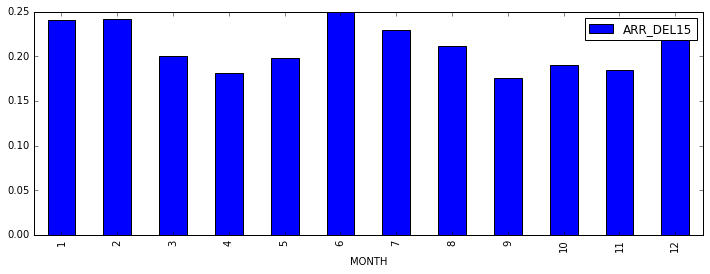

In [13]:
# Compute average number of delayed flights per month
grouped = training[['ARR_DEL15', 'MONTH']].groupby('MONTH').mean()

# plot average delays by month
grouped.plot(kind='bar')

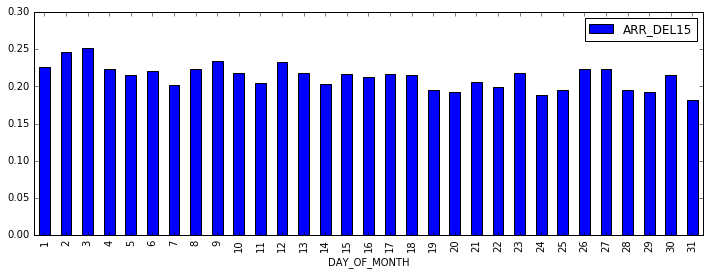

In [14]:
# Compute average number of delayed flights per month
grouped = training[['ARR_DEL15', 'DAY_OF_MONTH']].groupby('DAY_OF_MONTH').mean()

# plot average delays by month
grouped.plot(kind='bar')

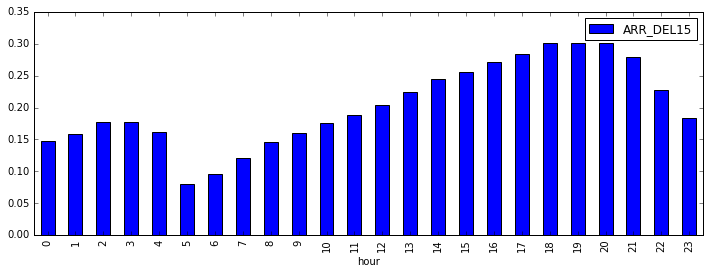

In [15]:
# Compute average number of delayed flights by hour
grouped = training[['ARR_DEL15', 'hour']].groupby('hour').mean()

# plot average delays by hour of day
grouped.plot(kind='bar')

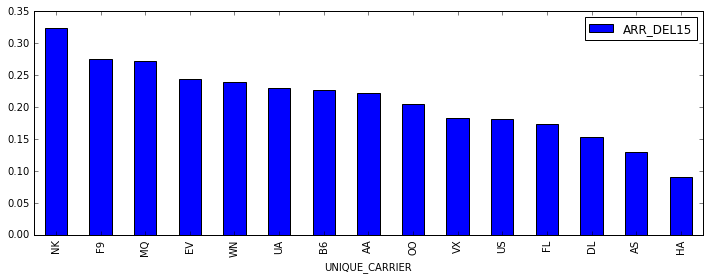

In [16]:
# Compute average number of delayed flights per carrier
grouped1 = training[['ARR_DEL15', 'UNIQUE_CARRIER']].groupby('UNIQUE_CARRIER').filter(lambda x: len(x)>15)
grouped2 = grouped1.groupby('UNIQUE_CARRIER').mean()
carrier = grouped2.sort(['ARR_DEL15'], ascending=False)

# display top 15 destination carriers by delay
carrier.plot(kind='bar')

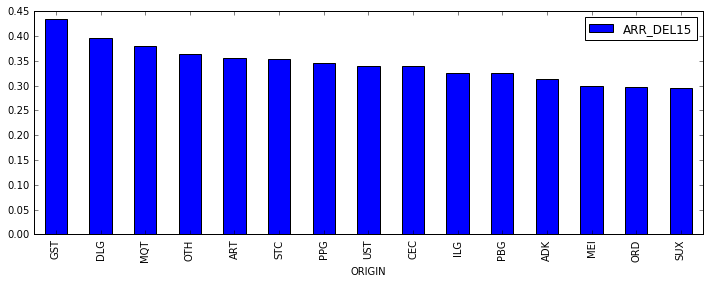

In [17]:
# Compute average number of delayed flights per origin airport
grouped1 = training[['ARR_DEL15', 'ORIGIN']].groupby('ORIGIN').filter(lambda x: len(x)>15)
grouped2 = grouped1.groupby('ORIGIN').mean()
carrier = grouped2.sort(['ARR_DEL15'], ascending=False)

# display top 15 origin airports by delay
carrier[:15].plot(kind='bar')

In [18]:
# There's a large difference in the amount of data for delayed vs. on time flights
print len(training[training['ARR_DEL15'] == 1]), len(training[training['ARR_DEL15'] == 0])

1814744 6682187


In [12]:
%%time
#Define the features in order to export the training set to a csv for quicker reinput
features_for_export = [c for c in training.columns if c in ['ARR_DEL15', 'days_from_holidays', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'DISTANCE', 'hour', 'orig_temperature_f', 'orig_dew_point_f', 'orig_humidity', 'orig_sea_level_pressure_in', 'orig_visibility_mph', 'orig_wind_speed_mph', 'orig_gust_speed_mph', 'orig_precipitation_in', 'orig_events', 'orig_conditions', 'orig_wind_dir_degrees', 'dest_temperature_f', 'dest_dew_point_f', 'dest_humidity', 'dest_sea_level_pressure_in', 'dest_visibility_mph', 'dest_wind_speed_mph', 'dest_gust_speed_mph', 'dest_precipitation_in', 'dest_events', 'dest_conditions', 'dest_wind_dir_degrees']]

CPU times: user 93 µs, sys: 16 µs, total: 109 µs
Wall time: 99.9 µs


In [19]:
%%time
training[features_for_export].to_csv('combined_data.csv', index=False)

CPU times: user 5min 3s, sys: 12.8 s, total: 5min 16s
Wall time: 5min 24s


In [2]:
%%time
#Create training set from combined data already saved to csv
training = pd.read_csv('combined_data.csv', iterator=True, chunksize=100000)
training = pd.concat([chunk for chunk in training], ignore_index=True)

CPU times: user 53 s, sys: 7.49 s, total: 1min
Wall time: 1min 1s


In [3]:
%%time
# Reduce the number of on time training instances so that the model will fit more easily into memory
# Keep all delayed instances and take random instances of on time flights equal to the number of
# delayed instances
delayed = training[training['ARR_DEL15'] == 1]
on_time = training[training['ARR_DEL15'] == 0]
sample_rows = np.random.choice(on_time.index.values, len(delayed))
on_time = on_time.ix[sample_rows]
training = pd.concat([on_time, delayed], ignore_index=True)

CPU times: user 10.6 s, sys: 7.57 s, total: 18.2 s
Wall time: 19.4 s


In [4]:
%%time
labels = training['ARR_DEL15']
training = training.drop('ARR_DEL15', 1)

CPU times: user 414 ms, sys: 411 ms, total: 825 ms
Wall time: 825 ms


In [5]:
%%time
# Transform the string labels to numerical using label encoder 
training.UNIQUE_CARRIER = le.fit_transform(training.UNIQUE_CARRIER)
training.ORIGIN = le.fit_transform(training.ORIGIN)
training.DEST = le.fit_transform(training.DEST)

CPU times: user 9.14 s, sys: 173 ms, total: 9.32 s
Wall time: 9.33 s


In [6]:
%%time
categ = [list(training.columns).index(x) for x in 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'hour']
enc = preprocessing.OneHotEncoder(categorical_features = categ)
training['UNIQUE_CARRIER'] = pd.factorize(training['UNIQUE_CARRIER'])[0]
training['ORIGIN'] = pd.factorize(training['ORIGIN'])[0]
training['DEST'] = pd.factorize(training['DEST'])[0]
sparse_train = enc.fit_transform(training)
print sparse_train.shape

(3629488, 758)
CPU times: user 7.24 s, sys: 5.79 s, total: 13 s
Wall time: 16.8 s


In [7]:
%%time
# Create training and testing sets using cross validation
features_train_1, features_test_1, labels_train_1, labels_test_1 = cross_validation.train_test_split(sparse_train, labels, test_size=0.70)
features_train_2, features_test_2, labels_train_2, labels_test_2 = cross_validation.train_test_split(features_train_1, labels_train_1, test_size=0.70)
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features_train_2, labels_train_2, test_size=0.70)

CPU times: user 7.93 s, sys: 2.35 s, total: 10.3 s
Wall time: 10.8 s


In [8]:
%%time
#d_tree = tree.DecisionTreeClassifier(min_samples_split=1000).fit(features_train, labels_train)
# Best so far: clf_rf = ensemble.RandomForestClassifier(n_estimators=50, n_jobs=-1, min_samples_split=50).fit(features_train, labels_train)
# forest = ensemble.RandomForestClassifier(n_estimators=50, n_jobs=-1).fit(features_train, labels_train)
# naive = GaussianNB().fit(features_train, labels_train)
forest = ensemble.RandomForestClassifier(n_estimators=100, n_jobs=-1).fit(features_train, labels_train)

CPU times: user 9min 54s, sys: 1.92 s, total: 9min 56s
Wall time: 2min 38s


In [9]:
%%time
# Evaluate on test set
pred = forest.predict(features_test)


# print results
cm = confusion_matrix(labels_test, pred)
print("Confusion matrix")
print(pd.DataFrame(cm))

report_rf = precision_recall_fscore_support(list(labels_test), list(pred), average='micro')
print "precision = %0.2f, recall = %0.2f, F1 = %0.2f, accuracy = %0.2f\n" % \
        (report_rf[0], report_rf[1], report_rf[2], metrics.roc_auc_score(list(labels_test.values), list(pred)))

Confusion matrix
       0      1
0  71922  43001
1  44020  69715


/Users/arkham/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


precision = 0.62, recall = 0.61, F1 = 0.62, accuracy = 0.62

CPU times: user 15.3 s, sys: 731 ms, total: 16 s
Wall time: 5.47 s


In [10]:
%%time
def modelfit(alg, features, labels, useTrainCV=True, cv_folds=5, early_stopping_rounds=20):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(features, label=labels)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics=['auc'], early_stopping_rounds=early_stopping_rounds, show_progress=True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(features, labels, eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(features)
    dtrain_predprob = alg.predict_proba(features)[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(labels.values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(labels, dtrain_predprob)
                    
#     feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')

CPU times: user 7 µs, sys: 1e+03 ns, total: 8 µs
Wall time: 12.9 µs


In [11]:
%%time
xgb_final =  xgb.XGBClassifier(
 learning_rate = 1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb_final, features_train_1, labels_train_1)

Will train until cv error hasn't decreased in 20 rounds.
[0]	cv-test-auc:0.5971034+0.00393730824803	cv-train-auc:0.5972822+0.00315987926352
[1]	cv-test-auc:0.6304+0.00220948509839	cv-train-auc:0.6311262+0.00264534772005
[2]	cv-test-auc:0.6450146+0.00227191378358	cv-train-auc:0.6462168+0.00216161295333
[3]	cv-test-auc:0.6535628+0.00352969536363	cv-train-auc:0.6553766+0.00184536019248
[4]	cv-test-auc:0.6595458+0.00243315822749	cv-train-auc:0.6615238+0.000734351795804
[5]	cv-test-auc:0.6637502+0.00299301248912	cv-train-auc:0.665964+0.00162332954141
[6]	cv-test-auc:0.666931+0.00271475774241	cv-train-auc:0.6695058+0.00124030841326
[7]	cv-test-auc:0.670237+0.00184305355321	cv-train-auc:0.6729646+0.00136936358941
[8]	cv-test-auc:0.6728234+0.00140291148687	cv-train-auc:0.6757788+0.0010769080555
[9]	cv-test-auc:0.6744756+0.00134232732223	cv-train-auc:0.677651+0.000999066564349
[10]	cv-test-auc:0.6766078+0.00168946588009	cv-train-auc:0.680044+0.00106782320634
[11]	cv-test-auc:0.6781976+0.0022504


Model Report
Accuracy : 0.6944
AUC Score (Train): 0.764063
CPU times: user 2h 14min 20s, sys: 36.4 s, total: 2h 14min 57s
Wall time: 2h 15min 28s


In [12]:
%%time
boost =  xgb.XGBClassifier(
 learning_rate = 1,
 n_estimators=329,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27).fit(features_train_1, labels_train_1)

CPU times: user 25min 39s, sys: 4.53 s, total: 25min 44s
Wall time: 25min 48s


In [13]:
%%time
# Evaluate on test set
pred = boost.predict(features_test_1)


# print results
cm = confusion_matrix(labels_test_1, pred)
print("Confusion matrix")
print(pd.DataFrame(cm))

report_rf = precision_recall_fscore_support(list(labels_test_1), list(pred), average='micro')
print "precision = %0.2f, recall = %0.2f, F1 = %0.2f, accuracy = %0.2f\n" % \
        (report_rf[0], report_rf[1], report_rf[2], metrics.roc_auc_score(list(labels_test_1.values), list(pred)))

Confusion matrix
        0       1
0  837740  433060
1  422714  847128


/Users/arkham/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


precision = 0.66, recall = 0.67, F1 = 0.66, accuracy = 0.66

CPU times: user 1min 44s, sys: 8.74 s, total: 1min 53s
Wall time: 1min 55s
